# Local Spatial Autocorrelation

- focuses on each observation and it's surroundings
- like scores rather than summaries

In [17]:
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import geopandas as gpd
import pandas as pd
import rioxarray as rxr
import xarray as xr
from pysal.explore import esda
from pysal.lib import weights
import contextily as ctx
from splot import esda as esdaplot

In [3]:
ref = pd.read_csv('../data/brexit_vote.csv', index_col='Area_Code') 
ref.iloc[1]

id                               109
Region_Code                E12000006
Region                          East
Area                           Luton
Electorate                    127612
ExpectedBallots                84633
VerifiedBallotPapers           84636
Pct_Turnout                    66.31
Votes_Cast                     84616
Valid_Votes                    84481
Remain                         36708
Leave                          47773
Rejected_Ballots                 135
No_official_mark                   0
Voting_for_both_answers           85
Writing_or_mark                    0
Unmarked_or_void                  50
Pct_Remain                     43.45
Pct_Leave                      56.55
Pct_Rejected                    0.16
Name: E06000032, dtype: object

In [4]:
lads = gpd.read_file(
    '../data/local_authority_districts.geojson'
).set_index("lad16cd")

In [5]:
db = (
    gpd.GeoDataFrame(
        lads.join(ref[["Pct_Leave"]]), crs=lads.crs
    )
    .to_crs(epsg=3857)[
        ["objectid", "lad16nm", "Pct_Leave", "geometry"]
    ]
    .dropna()
)

db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 380 entries, E06000001 to W06000023
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   objectid   380 non-null    int32   
 1   lad16nm    380 non-null    object  
 2   Pct_Leave  380 non-null    float64 
 3   geometry   380 non-null    geometry
dtypes: float64(1), geometry(1), int32(1), object(1)
memory usage: 13.4+ KB


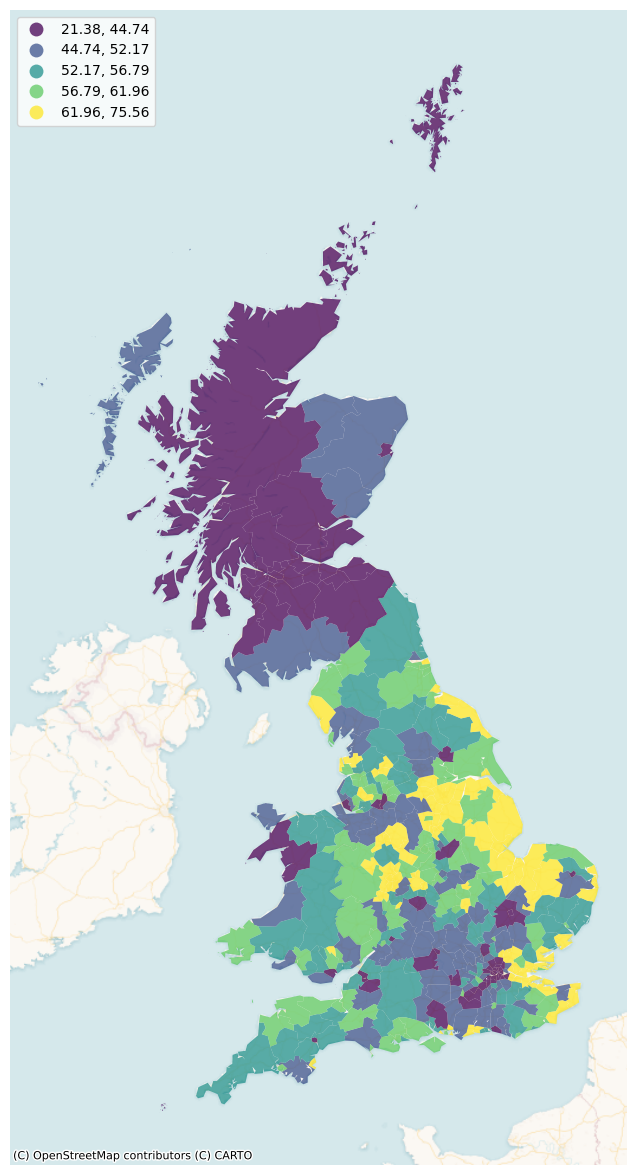

In [6]:
f, ax = plt.subplots(figsize=(10, 15))
db.plot(
    column='Pct_Leave', 
    cmap='viridis', 
    scheme='quantiles', k=5, 
    ec='w', lw=0.0, alpha=0.75, 
    legend=True, legend_kwds=dict(loc=2), 
    ax=ax
)
ctx.add_basemap(ax, crs=db.crs, source=ctx.providers.CartoDB.VoyagerNoLabels)
ax.set_axis_off();

>Generate weights for 8 nearest neighbors and standardize rows

In [7]:
w = weights.distance.KNN.from_dataframe(db, k=8)
w.transform = 'R'

>Visualize with Moran plot
>
>Calculate weights and centered weights

In [9]:
db['w_Pct_Leave'] = weights.lag_spatial(w, db.Pct_Leave)
db['Pct_Leave_std'] = db.Pct_Leave - db.Pct_Leave.mean() 
db['w_Pct_Leave_std'] = weights.lag_spatial(w, db.Pct_Leave_std)

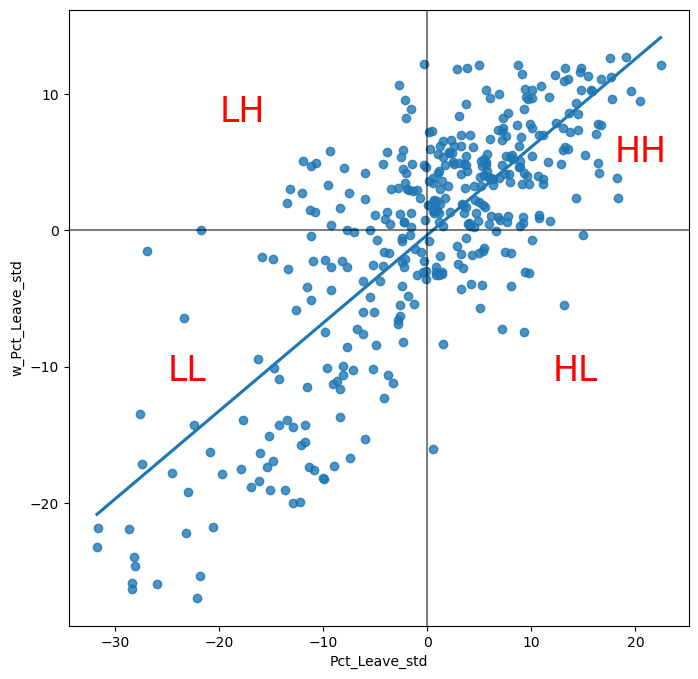

In [14]:
f, ax = plt.subplots(figsize=(8,8))
sns.regplot(
    db, x='Pct_Leave_std', y='w_Pct_Leave_std', ci=None
)
plt.axvline(0, c="k", alpha=0.5)
plt.axhline(0, c="k", alpha=0.5)
# Add text labels for each quadrant
plt.text(18, 5, "HH", fontsize=25, c="r")
plt.text(12, -11, "HL", fontsize=25, c="r")
plt.text(-20, 8.0, "LH", fontsize=25, c="r")
plt.text(-25, -11.0, "LL", fontsize=25, c="r");

>__Local Indicators of Spatial Association__ LISA

In [15]:
lisa = esda.moran.Moran_Local(db.Pct_Leave, w)

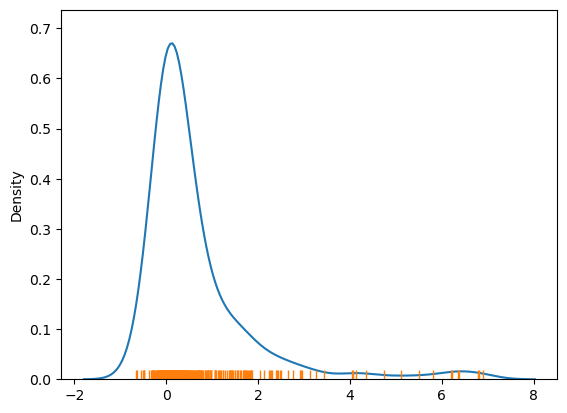

In [16]:
ax = sns.kdeplot(lisa.Is)
sns.rugplot(lisa.Is, ax=ax);

>Still does not distinguish HH from LL

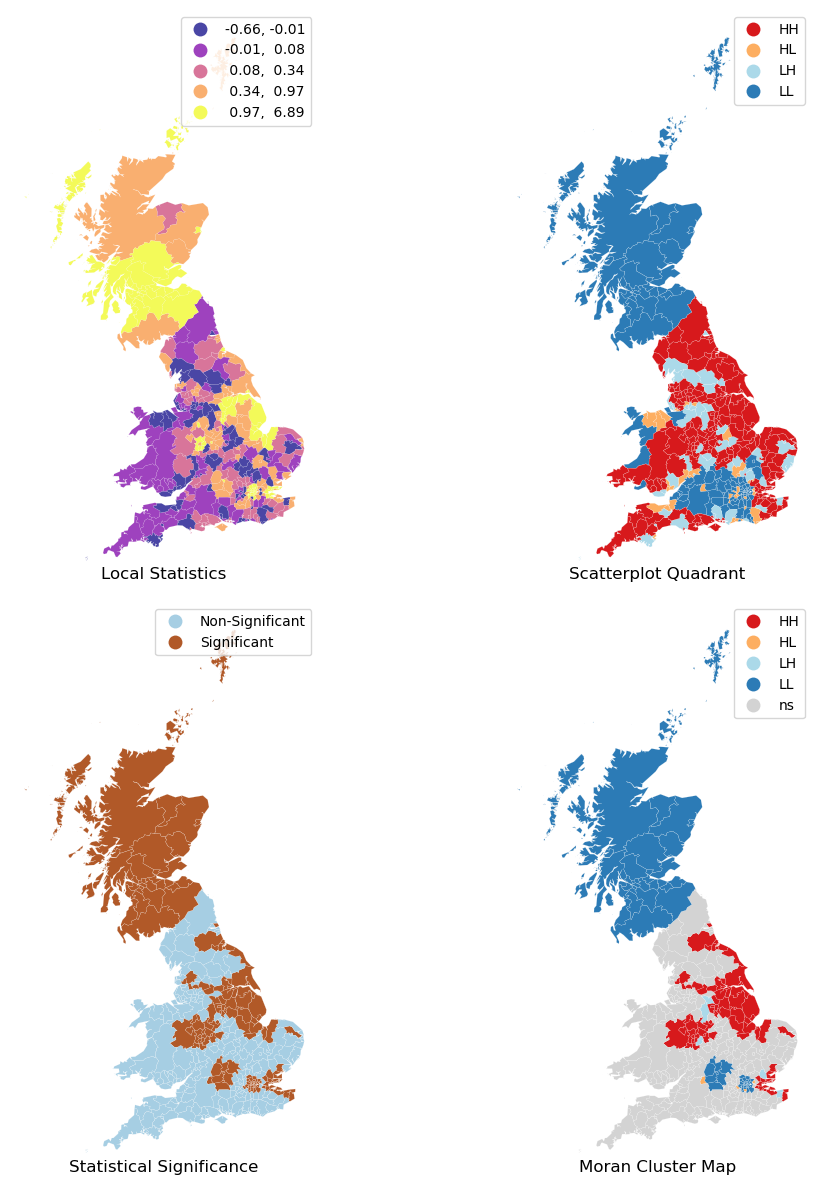

In [22]:
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
axs = axs.flatten()

ax = axs[0]
db.assign(
    Is=lisa.Is
).plot(
    column="Is",
    cmap="plasma",
    scheme="quantiles", k=5,
    ec="white", lw=0.1, alpha=0.75,
    legend=True,
    ax=ax,
)

ax = axs[1]

esdaplot.lisa_cluster(lisa, db, p=1, ax=ax)
ax = axs[2]
labels = pd.Series(
    1 * (lisa.p_sim < 0.05),  # Assign 1 if significant, 0 otherwise
    index=db.index  # Use the index in the original data
    # Recode 1 to "Significant and 0 to "Non-significant"
).map({1: "Significant", 0: "Non-Significant"})
# Assign labels to `db` on the fly
db.assign(
    cl=labels
    # Plot choropleth of (non-)significant areas
).plot(
    column="cl",
    categorical=True,
    k=2,
    cmap="Paired",
    linewidth=0.1,
    edgecolor="white",
    legend=True,
    ax=ax,
)

ax = axs[3]
esdaplot.lisa_cluster(lisa, db, p=0.05, ax=ax)

for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            "Local Statistics",
            "Scatterplot Quadrant",
            "Statistical Significance",
            "Moran Cluster Map",
        ][i],
        y=0,
    )

f.tight_layout()

plt.show()

In [24]:
lisa.q[:10]

array([1, 1, 1, 1, 1, 1, 4, 1, 4, 1])

In [27]:
counts = pd.Series(lisa.q).value_counts()
counts

1    183
3    113
2     50
4     34
Name: count, dtype: int64

In [28]:
(lisa.p_sim < 0.05).sum() * 100 / len(lisa.p_sim)

40.0

In [30]:
db['p-sim'] = lisa.p_sim
db['sig'] = 1 * (lisa.p_sim < 0.05)
db[['sig', 'p-sim']].head()

,sig,p-sim
lad16cd,,
E06000001,1,0.016
E06000002,1,0.013
E06000003,1,0.017
E06000004,1,0.016
E06000010,1,0.018


In [32]:
db[["sig", "p-sim"]].tail()

,sig,p-sim
lad16cd,,
W06000018,0,0.495
W06000019,0,0.486
W06000021,0,0.473
W06000022,0,0.351
W06000023,0,0.278


In [34]:
spots = lisa.q * sig 
spots_labels = {
    0: 'Non-signiicant',
    1: 'HH', 2: 'LH', 3: 'LL', 4: 'HL'
}
db['labels'] = pd.Series(
    spots, index=db.index
).map(spots_labels)
db.labels.head()

lad16cd
E06000001    HH
E06000002    HH
E06000003    HH
E06000004    HH
E06000010    HH
Name: labels, dtype: object

In [35]:
db.labels.value_counts()

labels
Non-signiicant    228
HH                 73
LL                 70
LH                  5
HL                  4
Name: count, dtype: int64

>Most local statistics ar not significant.

# Getis and Ord's Local Statistics 

>This code failed

# Local statistics on surfaces

In [41]:
pop = rxr.open_rasterio('../data/ghsl_sao_paulo.tif')

In [44]:
w_surface_sp = weights.Queen.from_xarray(pop) 
w_surface_sp.sparse.dtype

dtype('int8')

In [45]:
type(w_surface_sp)

libpysal.weights.weights.WSP

>Convert to W object and change to float

In [46]:
w_surface_all = weights.WSP2W(
    weights.WSP(
        w_surface_sp.sparse.astype(float), 
        id_order=w_surface_sp.index.tolist()
    )
)
w_surface_all.index = w_surface_sp.index

In [47]:
pop_values = pop.to_series() 
pop_values = pop_values[pop_values != pop.rio.nodata]
pop.rio.nodata

-200.0

In [48]:
w_surface = weights.w_subset(w_surface_all, pop_values.index)
w_surface.index = pop_values.index

In [51]:
pop_lisa = esda.moran.Moran_Local(
    pop_values.astype(float), w_surface, n_jobs=1
)

In [52]:
from libpysal.weights import raster

In [53]:
sig_pop = pd.Series(
    pop_lisa.q * (pop_lisa.p_sim < 0.01),
    index=pop_values.index
)

In [54]:
lisa_da = raster.w2da(
    sig_pop, 
    w_surface, 
    attrs=dict(nodatavals=[pop.rio.nodata])
).rio.write_crs(pop.rio.crs)

In [55]:
lisa_da.to_series().unique()

array([-200,    0,    3,    1,    2,    4])

In [56]:
from matplotlib.colors import ListedColormap

In [63]:
lc = dict(
    ns='lightgrey', 
    HH='#d7191c', 
    LH='#abd9e9', 
    LL='#2c7bb6', 
    HL='#fdae61'
)

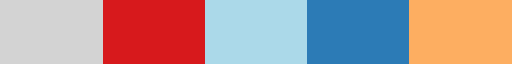

In [64]:
lisa_cmap = ListedColormap(
    [lc['ns'], lc['HH'], lc['LH'], lc['LL'], lc['HL']]
)
lisa_cmap

In [67]:
print(lisa_cmap.colors)

['lightgrey', '#d7191c', '#abd9e9', '#2c7bb6', '#fdae61']


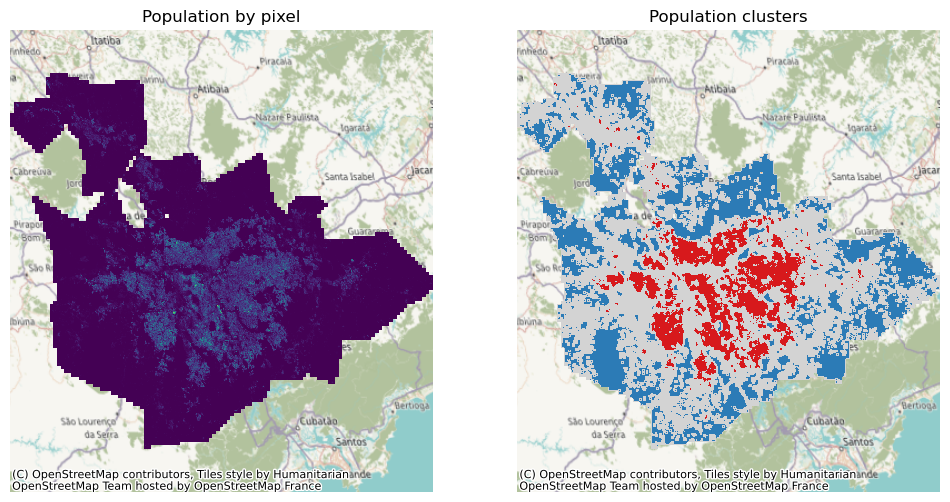

In [68]:
f, axs = plt.subplots(1, 2, figsize=(12,6))
pop.where(
    pop != pop.rio.nodata
).plot(ax=axs[0], add_colorbar=False)

(lisa_da.where(lisa_da != -200) / 4
).plot(cmap=lisa_cmap, ax=axs[1], add_colorbar=False)

titles = ["Population by pixel", "Population clusters"]
for i in range(2): 
    axs[i].axis('equal')
    axs[i].set_axis_off() 
    axs[i].set_title(titles[i])
    ctx.add_basemap(axs[i], crs=lisa_da.rio.crs)